In [17]:
import numpy as np
import pandas as pd
import datetime as dt
import importlib

from packages import tools
from packages import models

from sklearn import metrics

In [120]:
price_path = "Datasets/DAMPrices.csv"
prices = tools.read_price_data(price_path)

In [121]:
"""
Parameters:
    data: pd.DataFrame
        - Observed data
    forecast:pd.DataFrame
        - Forecast data
"""
def calculate_errors(data, forecast): 
    # Combine forecast data with the corresponding observed/test/historical data.
    combined_df = forecast.merge(data, how="left", left_index=True, right_index=True, suffixes=("_forecast", "_data"))
    
    # Calculate residuals, absolute error and squared error of predicted values, respectively.
    combined_df["residual"] = combined_df["EURPrices_data"] - combined_df["EURPrices_forecast"]
    combined_df["absolute_error"] = abs(combined_df["residual"])
    combined_df["squared_error"] = combined_df["residual"] ** 2
    
    return(combined_df)

In [206]:
# Walk-forward evaluation of a forecasting model
"""
Parameters:
    method_function: function
    parameters: dictionary
        - parameters specific to method_function
    data: pd.DataFrame
    starting_window_size: int
        - number of days worth of data to start the training set on
    moving_window: bool
        - To specify whether the training window is a moving window or an expanding window.
    start: datetime
        - Date on which to start the walk-forward validation.
    end: datetime
        - Date to end the walk-forward validation on (inclusive).
"""
def walk_forward_evaluation(method_function, parameters, data, starting_window_size, moving_window=False, start=None, end=None):
    # Raise error if training data is not large enough for starting_window_size
    if (start-data.index[0]).days < starting_window_size:
        raise Exception(f"Not enough data for training: starting_window_size={starting_window_size}, train_size={start-data.index[0]}")
    
    # Create initial training data window
    train_dates = list(pd.date_range(end=start-dt.timedelta(hours=1), periods=24*starting_window_size, freq="h"))
    train_data = data.loc[train_dates,:]
    
    # Create dataframe to store errors
    forecast_index = pd.date_range(start=start, end=end+dt.timedelta(hours=23), freq="h")
    forecasts_df = pd.DataFrame(columns=["Forecast"], index=forecast_index)
    forecasts_df.insert(0, "Original", data["EURPrices"].loc[forecast_index])

    # Loop through data to train and forecast iteratively over the expanding (or moving) window
    # using the specific model defined by method_function.
    for _ in range((end-start).days+1):
        if method_function == models.naive:
            # Generate forecasts (no training here since naive model doesn't need to be trained)
            forecast = method_function(data=train_data, **parameters)
            forecasts_df.loc[forecast.index, "Forecast"] = forecast.values
        
        # Extend data window (or move forward, if moving_window=True) by 1 day to include the next day of data
        if moving_window:
            train_data.drop(train_data.index[:24], inplace=True)
        next_date = list(pd.date_range(start=train_data.index[-1]+dt.timedelta(hours=1), periods=24, freq="h"))
        new_data = data.loc[next_date,:]
        train_data = train_data.append(new_data)
      
    return(forecasts_df)

In [217]:
naive1_params = dict(day_lag=1)
naive2_params = dict(day_lag=2)
naive7_params = dict(day_lag=7)
naive14_params = dict(day_lag=14)

res1 = walk_forward_evaluation(method_function=models.naive, parameters=naive1_params, data=prices,
                        starting_window_size=14, moving_window=True, start=dt.datetime(2019,11,13), end=dt.datetime(2020,5,22))
res2 = walk_forward_evaluation(method_function=models.naive, parameters=naive2_params, data=prices,
                        starting_window_size=14, moving_window=True, start=dt.datetime(2019,11,13), end=dt.datetime(2020,5,22))
res7 = walk_forward_evaluation(method_function=models.naive, parameters=naive7_params, data=prices,
                        starting_window_size=14, moving_window=True, start=dt.datetime(2019,11,13), end=dt.datetime(2020,5,22))
res14 = walk_forward_evaluation(method_function=models.naive, parameters=naive14_params, data=prices,
                        starting_window_size=14, moving_window=True, start=dt.datetime(2019,11,13), end=dt.datetime(2020,5,22))

<IPython.core.display.Javascript object>


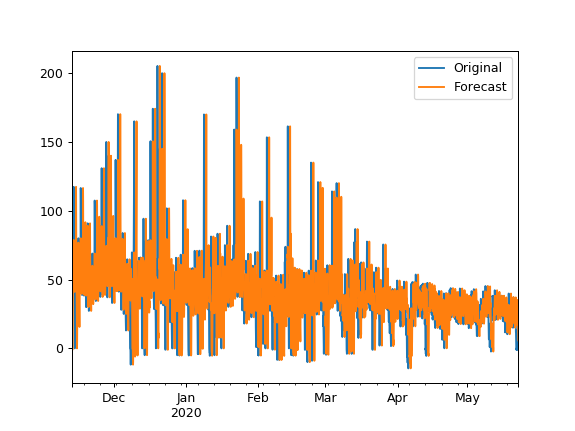

<IPython.core.display.Javascript object>


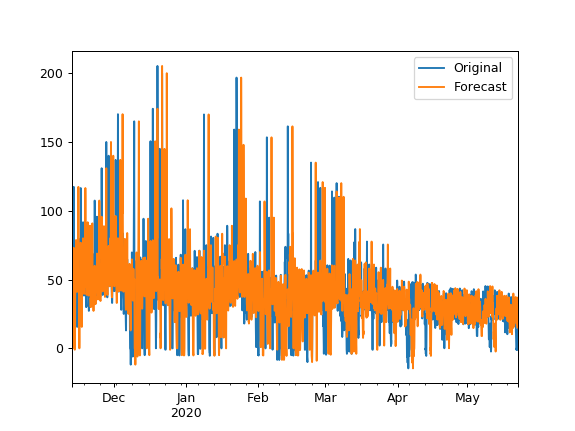

<IPython.core.display.Javascript object>


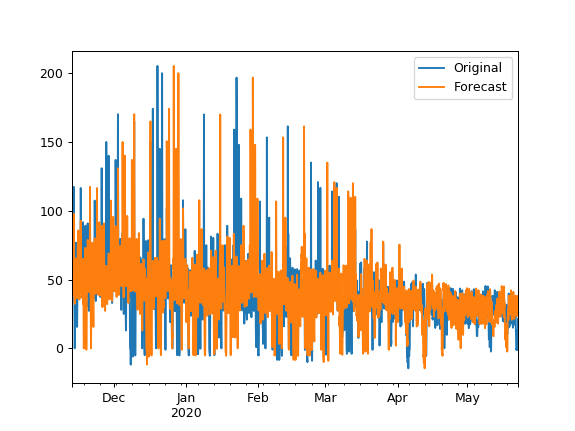

<IPython.core.display.Javascript object>


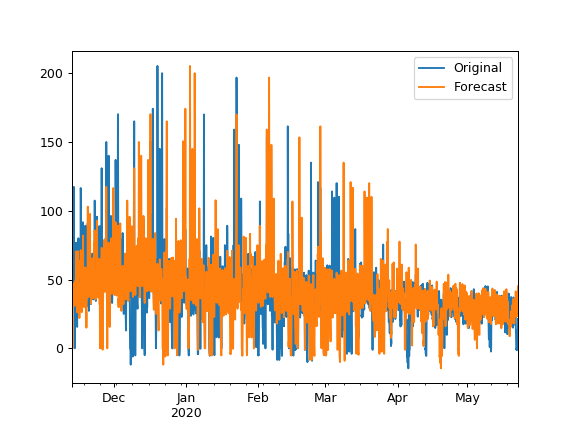

In [218]:
%matplotlib nbagg
res1.plot()
res2.plot()
res7.plot()
res14.plot()

In [220]:
print("MSEs:")
print(metrics.mean_squared_error(res1["Original"], res1["Forecast"], squared=False))
print(metrics.mean_squared_error(res2["Original"], res2["Forecast"], squared=False))
print(metrics.mean_squared_error(res7["Original"], res7["Forecast"], squared=False))
print(metrics.mean_squared_error(res14["Original"], res14["Forecast"], squared=False))
print("\nMAEs:")
print(metrics.mean_absolute_error(res1["Original"], res1["Forecast"]))
print(metrics.mean_absolute_error(res2["Original"], res2["Forecast"]))
print(metrics.mean_absolute_error(res7["Original"], res7["Forecast"]))
print(metrics.mean_absolute_error(res14["Original"], res14["Forecast"]))

MSEs:
18.44679896757629
20.432825172956655
20.377076468087484
20.57902406011828

MAEs:
12.217884114583335
14.229020399305556
13.904351996527778
14.274292534722223
